### Use two different pretrained models for object detection

In [12]:
!pip install tensorflow-hub

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 23.6 MB/s eta 0:00:00


In [13]:
import tensorflow as tf 
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO


In [37]:
def load_image_from_url(url, target_size=(800, 600)):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    if target_size:
        image = image.resize(target_size)
    return np.array(image)


def plot_detections(image, boxes, classes, scores, threshold=0.5, title='Detections'):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    h, w, _ = image.shape 

    for box,cls, score in zip(boxes,classes, scores):
        if score < threshold:
            continue

        ymin, xmin, ymax, xmax = box
        xmin = int(xmin * w)
        xmax = int(xmax * w)
        ymin = int(ymin * h)
        ymax = int(ymax * h)
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)

        ax.add_patch(rect)
        ax.text(xmin, ymin, f'ID {int(cls)}: {score:.2f}', bbox=dict(facecolor='red', alpha=0.5), color='white')

    ax.set_title(title)
    plt.axis('off')
    plt.show()


In [38]:
## Downloading Image 

image_url = "https://www.ctvnews.ca/resizer/v2/FSCMLOB5BNUB6ZDGAL26OUOKKE.png?auth=8d3873c1e0b7ebe7658a17d6b22710b93e81e825d69fef428dc9cad71471d03c&width=800&height=450"
image_np = load_image_from_url(image_url, target_size=(800, 600))

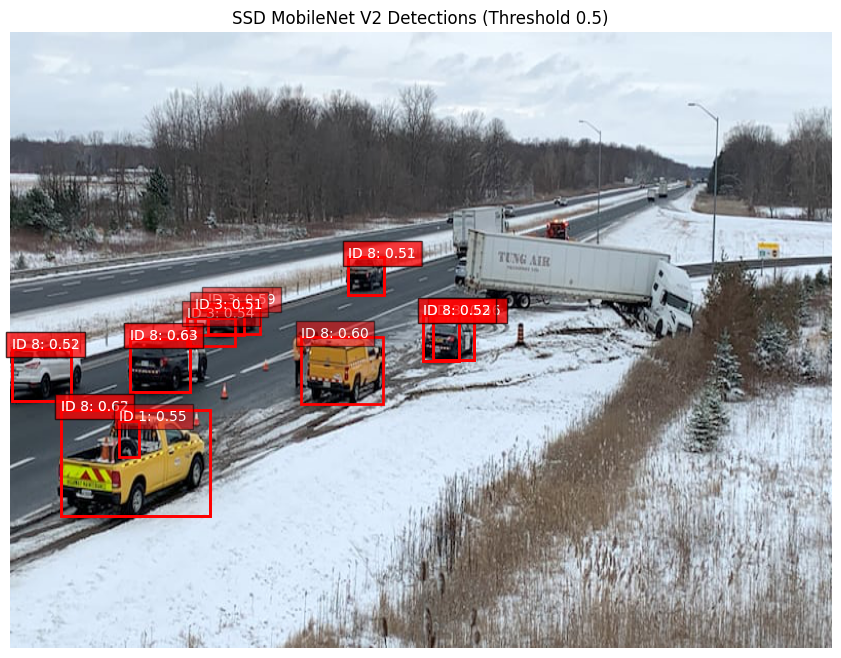

In [39]:
# Load the SSD MobileNet V2 model (version 2)
ssd_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
ssd_model = hub.load(ssd_url)

def run_ssd_inference(model, image):
    # Convert image to uint8 and add batch dimension (model expects tf.uint8)
    img_tensor = tf.convert_to_tensor(image, dtype=tf.uint8)[tf.newaxis, ...]
    outputs = model(img_tensor)
    boxes = outputs["detection_boxes"].numpy()[0]
    scores = outputs["detection_scores"].numpy()[0]
    classes = outputs["detection_classes"].numpy()[0]
    return boxes, scores, classes

boxes_ssd, scores_ssd, classes_ssd = run_ssd_inference(ssd_model, image_np)
plot_detections(image_np, boxes_ssd, classes_ssd, scores_ssd, threshold=0.5,
                title="SSD MobileNet V2 Detections (Threshold 0.5)")


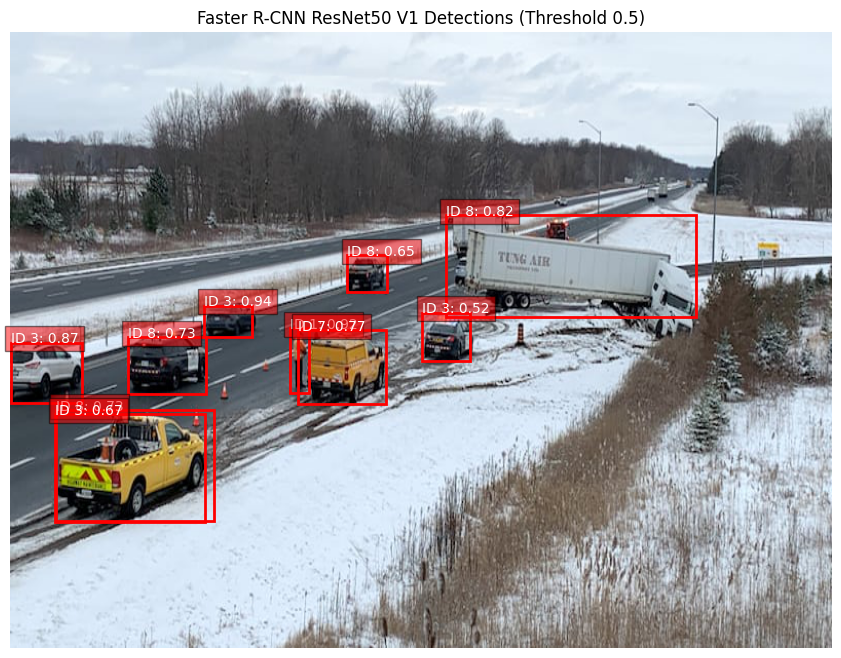

In [40]:
frcnn_url = "https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1"
frcnn_model = hub.load(frcnn_url)

def run_frcnn_inference(model, image):
    # Faster R-CNN expects a uint8 image with a batch dimension.
    img_tensor = tf.convert_to_tensor(image, dtype=tf.uint8)[tf.newaxis, ...]
    outputs = model(img_tensor)
    boxes = outputs["detection_boxes"].numpy()[0]
    scores = outputs["detection_scores"].numpy()[0]
    classes = outputs["detection_classes"].numpy()[0]
    return boxes, scores, classes

boxes_frcnn, scores_frcnn, classes_frcnn = run_frcnn_inference(frcnn_model, image_np)
plot_detections(image_np, boxes_frcnn, classes_frcnn, scores_frcnn, threshold=0.5,
                title="Faster R-CNN ResNet50 V1 Detections (Threshold 0.5)")